Using historic data
using public sentiment - sentiment analysis
using XGBoost model

In [29]:
from watermark import watermark
# Imports
import sys
import os
import platform
from os.path import exists


In [30]:
# Report Technologies
print(f'Python Platform: {platform.platform()}')
print(f'Python {sys.version}')
print(watermark())
print(watermark(iversions=True, globals_=globals()))

Python Platform: macOS-13.0.1-arm64-arm-64bit
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Last updated: 2023-05-05T21:50:56.015256-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

mwclient: 0.10.1
pandas  : 1.5.2
sys     : 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
platform: 1.0.8



In [31]:
# Using wikipedia BTC page edit history as proxy for public interest and sentiment
# - additional potential sources for 'sentiment analysis' => tweets, google trends
"""
    Downloading wikipedia edits for BTC  """

'\n    Downloading wikipedia edits for BTC  '

In [32]:
import mwclient  # Module for interacting with MediaWiki API.
import time  # Module for handling time-related operations.

# Initialize a MediaWiki client site which is a class that enables work with a specific wiki site,
# in this case, the English (en) version of Wikipedia.
site = mwclient.Site('en.wikipedia.org')  # Replace 'en' with the appropriate language code for other sites.

# Specify which page to use by creating a Page object using the page's title.
page = site.pages['Bitcoin']  # Replace 'Bitcoin' with the title of alternatively desired Wikipedia page.


In [33]:
# obtain from wikipedia the list of revisions
revs = list(page.revisions()) #

In [34]:
# Obtain from Wikipedia the list of revisions for the specified page.
revs = list(page.revisions())  # Returns a list of dictionaries containing information about each revision of the page.
                              # Each dictionary contains keys such as 'user', 'comment', 'timestamp', etc. that provide
                              # details about the revision. The list is sorted in reverse chronological order by default.

In [35]:
# Look at the first set of revisions for the specified page.
# Outputs an ordered dictionary, which is a Python class that functions as a hybrid-like list and dictionary combined.
revs[0]  # Returns a dictionary containing information about the first revision of the page.
         # The dictionary contains keys such as 'user', 'comment', 'timestamp', etc. that provide details about the revision.
         # The specific information returned depends on the MediaWiki API and the parameters used to query the revisions.


OrderedDict([('revid', 1151233254),
             ('parentid', 1149274508),
             ('minor', ''),
             ('user', 'Rodw'),
             ('timestamp',
              time.struct_time(tm_year=2023, tm_mon=4, tm_mday=22, tm_hour=18, tm_min=46, tm_sec=9, tm_wday=5, tm_yday=112, tm_isdst=-1)),
             ('comment',
              'Disambiguating links to [[Central American University]] (link changed to [[Central American University (San Salvador)]]) using [[User:Qwertyytrewqqwerty/DisamAssist|DisamAssist]].')])

In [36]:
# Sort the list of revisions for the specified page in ascending order based on their timestamps.
# The sorted() function is used here with a key parameter, which takes a function that returns a value to sort by.
# In this case, the lambda function returns the timestamp value from each revision dictionary.
revs = sorted(revs, key=lambda rev: rev['timestamp'])  # Returns the same list of revision dictionaries, but sorted
                                                       # in ascending order by their timestamps.

In [37]:
# Look at the first revision in the sorted/reordered list of revisions for the specified page.
# Outputs an ordered dictionary, which is a Python class that functions as a hybrid-like list and dictionary combined.
revs[0]  
# Returns a dictionary containing information about the first revision of the page in the sorted list.

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

# Identifying the 'sentiment'of the wikipedia page edits

In [38]:
# Provides for pipeline to 'deep learning' models; requires TensorFlow 2.0 or PyTorch
from transformers import pipeline  # import the transformers library, which includes the pipeline function for running pre-trained models

from typing import List, Tuple  # import List and Tuple types from the typing module for type hinting

sentiment_pipeline = pipeline("sentiment-analysis")  # initialize the Deep Learning sentiment analysis model using the pipeline function from transformers

def find_sentiment(text: str) -> float:
    """
    This function takes in a string of text and returns a sentiment score between -1 and 1,
    where negative values indicate negative sentiment and positive values indicate positive sentiment.
    """
    sent: List[dict] = sentiment_pipeline([text[:259]])[0]  # run the text through the sentiment analysis model and get the first (and only) result
    score: float = sent['score']  # extract the sentiment score from the model output
    if sent['label'] == 'NEGATIVE':  # check if the sentiment label is negative
        score *= -1  # if so, multiply the score by -1 to indicate negative sentiment
    return score  # return the sentiment score


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [39]:
# Test sentiment function operation
test_positive_sent = find_sentiment('I love you') 
print(test_positive_sent)

test_negative_sent = find_sentiment('I despise you') 
print(test_negative_sent)

test_neutral_sent = find_sentiment('I neutral you') 
print(test_neutral_sent)

0.9998656511306763
-0.9928188920021057
-0.9936189651489258


In [40]:
from typing import Dict, List, Any
import time

# Define the 'edits' dictionary
edits: Dict[str, Dict[str, Any]] = {}

# Iterate through the revisions in the sorted list 'revs'
for rev in revs:
    # Get the date of the revision using the 'timestamp' attribute
    date: str = time.strftime('%Y-%m-%d', rev['timestamp'])
    
    # Check if the date is not in the 'edits' dictionary
    if date not in edits:
        # If the date is not in the 'edits' dictionary, create a new dictionary with the following attributes:
        # - 'sentiments': a list to store the sentiment analysis scores
        # - 'edt_count': an integer to store the number of edits made on the date
        edits[date]: Dict[str, Any] = {'sentiments': [], 'edt_count': 0}
        
    # Increment the 'edt_count' by 1 for the current date
    edits[date]['edt_count'] += 1
        
    # Get the comment for the revision
    comment: str = rev['comment']
    
    # Call the 'find_sentiment' function to get the sentiment score for the comment
    sentiment_score: float = find_sentiment(comment)
    
    # Append the sentiment score to the 'sentiments' list for the current date
    edits[date]['sentiments'].append(sentiment_score)


KeyboardInterrupt: 

In [ ]:
from statistics import mean  # import mean function from statistics module

# iterate through each key in the edits dictionary
for key in edits:
    
    # check if there are any sentiments present for the current key
    if len(edits[key]['sentiments']) > 0:
        
        # calculate the mean sentiment for the current key
        edits[key]['sentiment'] = mean(edits[key]['sentiments'])
        
        # calculate the negative sentiment score as a ratio of the total sentiment scores
        edits[key]['neg_sentiment'] = len([s for s in edits[key]['sentiments'] if s < 0]) / len(edits[key]['sentiments'])
                                           
    # if there are no sentiments present for the current key
    else:
        
        # set the sentiment score to 0
        edits[key]['sentiment'] = 0
                                           
        # set the negative sentiment score to 0
        edits[key]['neg_sentiment'] = 0

        # remove the 'sentiments' key from the current key in the 'edits' dictionary
        del edits[key]['sentiments']


# generate a dataframe with sentiment data

In [ ]:
# Import pandas module for creating and manipulating dataframes
import pandas as pd

# Create a dataframe 'edits_df' from the dictionary 'edits' with index orientation set to 'index'
edits_df = pd.DataFrame.from_dict(edits, orient='index')

In [3]:
# Exploratory data anlysis
# Downloading assets/securities price data (i.e. S&P 500)

In [4]:
# import yfinance package as package for data source
import yfinance as yf  # call yahoo finance API in order to download daily stock and indices prices

In [5]:
# initialize a ticker class to enable download of pricing history for. single, i.e. specified symbol
sp500 = yf.Ticker('^GSPC')  # GSPC is the S&P500 index

In [6]:
# to query historical prices
sp500 = sp500.history(period = 'max') # 'max' allows to query ALL data from beginning of index creation in dataframe format

# visualize pandas dataframe
# each row representing data of a trading day with non-trading days excluded
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-01 00:00:00-04:00,4166.790039,4186.919922,4164.120117,4167.870117,3321370000,0.0,0.0
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000,0.0,0.0
2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000,0.0,0.0


In [7]:
# examine the dataframe index; note returns a 'date-time-index'
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-04-24 00:00:00-04:00', '2023-04-25 00:00:00-04:00',
               '2023-04-26 00:00:00-04:00', '2023-04-27 00:00:00-04:00',
               '2023-04-28 00:00:00-04:00', '2023-05-01 00:00:00-04:00',
               '2023-05-02 00:00:00-04:00', '2023-05-03 00:00:00-04:00',
               '2023-05-04 00:00:00-04:00', '2023-05-05 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=23951, freq=None)

In [8]:
# initiate preliminary data cleaning and visualization

<AxesSubplot:xlabel='Date'>

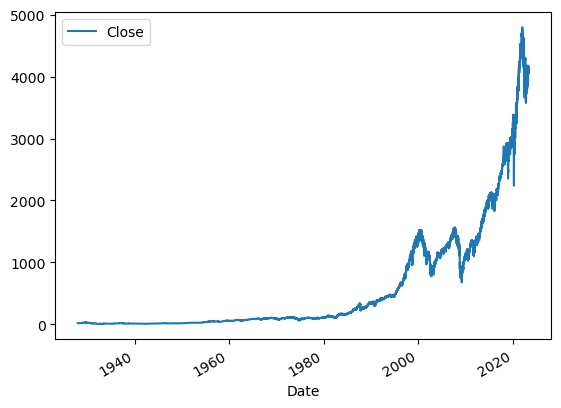

In [9]:
# visualize data frame data via plotting closing price column against the index
sp500.plot.line(y = 'Close', use_index = True)  # index values are x-axis and closing price is y-axis

In [10]:
# eliminate columns that provide zero value for our analysis of the S&P500 index
del sp500['Dividends']
del sp500['Stock Splits']

In [11]:
# Define target for Machine Learning, i.e. what we will actually utilize Machine Leanring to predict
# i.e. target / question is ~ will price go up or go down TOMORROW
# note, predicting direction will be both more successful and more advantagious / greater utility than attempting to predict absolute price

In [12]:
# Create a new column in our dataframe to provide tomorrow's price
# creating new dataframe column called 'Tomorrow' 
# use pandas function '.shift()' to move the values of the 'Close' column one row ahead and 
# assign them to the 'Tomorrow' column, creating new column with the previous day's closing price
sp500['Tomorrow'] = sp500['Close'].shift(-1)  


# Visualize updated 'sp500' dataframe with new 'Tomorrow' column containing previous day's closing price.
# allowing visualization if the market has gone up or down.
sp500 


,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-05-01 00:00:00-04:00,4166.790039,4186.919922,4164.120117,4167.870117,3321370000,4119.580078
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000,4090.750000
2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000,4061.219971


In [13]:
# Utilizing 'Tomorrow's' price, we will define our 'Target' as a new column in the dataframe
# creating a new column named 'Target' in the dataframe.
# comparing the values of the 'Tomorrow' column to the values of the 'Close' column
# This generates a boolean (True or False) value depending on whether the 'Tomorrow' price is greater than the 'Close' price. 
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close'])  

# using the pandas '.astype()' function to convert the 'Target' column boolean to integers. 
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)  

# Visualize updated 'sp500' dataframe with the new 'Target' column values changed from True or False to integer 1 or 0
# value of 1 means 'Tomorrow' price was greater than the 'Close' price
# value of 0 means that the 'Tomorrow' price was less than or equal to the 'Close' price.
sp500 

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-05-01 00:00:00-04:00,4166.790039,4186.919922,4164.120117,4167.870117,3321370000,4119.580078,0
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000,4090.750000,0
2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000,4061.219971,0


In [14]:
# Clean and/or streamline data by specifying a smaller range, i.e. how far back we will go for our starting point
# Use pandas '.loc' method to specify using only those rows that are at least the specified date or later,
# Use pandas '.copy()' method method returns a copy of the DataFrame, meaning (by default) any changes made in the original DataFrame will NOT be reflected in the copy.

sp500 = sp500.loc['1990-01-01':].copy() 
# Here, we are using the pandas '.loc' method to specify that we only want to keep rows in the 'sp500' dataframe 
# that have a date of January 1st, 1990 or later. 
# We are then using the '.copy()' method to make a copy of the resulting dataframe so that any changes made to the 
# copy will not affect the original dataframe. This ensures that we are working with a clean and streamlined dataset.

# Visualize the dataframe with the defined starting row 
sp500 
# Here, we are displaying the updated 'sp500' dataframe with the defined starting row of January 1st, 1990. 
# This allows us to focus on more recent data and remove any older data that may not be relevant to our analysis.


,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-05-01 00:00:00-04:00,4166.790039,4186.919922,4164.120117,4167.870117,3321370000,4119.580078,0
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000,4090.750000,0
2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000,4061.219971,0


In [15]:
# develop initial Machine Learning Model, i.e. training a 'random forest' model
# random forest, by design tendency towards resistance to 'overfitting'
# random forest generally relatively quick in operation
# random forest can identify or recognize 'non-linear' relationships of the data which is good in modeling securities

In [16]:
# import our first model package
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Initializing the model
# Set the random state, 'seed' to a specific value to ensure the same results are reproducible in the future
seed = 42 


# Create a Random Forest Classifier model with specified hyperparameters:
# n_estimators specify the number of random decision trees will use; generally accuracy improves with higher number of decision trees
#    setting the number of decision trees to 185, which is generally a good number for accuracy
# min_samples_split helps prevent overfitting by specifying the minimum number of samples required to split an internal node; the higher this value the LOWER the accuracy,
#    setting minimum number of samples required to split an internal node to 100, which helps to prevent overfitting.
# random_state is used to ensure the same random values are used for each run of the model for reproducibility
model = RandomForestClassifier(n_estimators=185, min_samples_split = 100, random_state = seed)

In [18]:
# split data into training and testing datasets
# need to split taking 'time series' nature into account, as random splitting will result in leakage, i.e. using tomorrow's data to predict today
train = sp500.iloc[:-100]  # training data set - use all data rows EXCEPT for the most recent/ last 100 rows
test =  sp500.iloc[-100:]  # testing data set - use the most recent/ last 100 rows

# select the columns that will be used to train the model
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']  # exclude the 'Target' and 'Tomorrow' columns to prevent leakage!

# train the model using the specified predictors and target variables
model.fit(train[predictors], train['Target'])


RandomForestClassifier(min_samples_split=100, n_estimators=185, random_state=42)

In [19]:
# use trained model using the '.predict()' method passing in 'test' set with the predictors to make predictions on the testing dataset
preds = model.predict(test[predictors])

# visualize predictions (note, default will be in numpy array format) 
preds


array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [20]:
import pandas as pd
# create new pandas series with predicted values using the 'preds' array and the index from the test dataset
preds = pd.Series(preds, index = test.index)

# visualize the predictions as a pandas series
preds

Date
2022-12-12 00:00:00-05:00    0
2022-12-13 00:00:00-05:00    0
2022-12-14 00:00:00-05:00    1
2022-12-15 00:00:00-05:00    1
2022-12-16 00:00:00-05:00    0
                            ..
2023-05-01 00:00:00-04:00    0
2023-05-02 00:00:00-04:00    1
2023-05-03 00:00:00-04:00    0
2023-05-04 00:00:00-04:00    0
2023-05-05 00:00:00-04:00    0
Length: 100, dtype: int64

In [21]:
# assess the accuracy of the model - require metrics package/s
from sklearn.metrics import (classification_report, 
                             balanced_accuracy_score,
                             precision_score,
                             confusion_matrix,
                             roc_auc_score,
                             f1_score)

In [22]:
# Calculating the precision score using predicted values 'preds' and actual values in the test set 'test['Target']'
precision_score_1 = precision_score(test['Target'], preds)

# visualize precision score
print(precision_score_1)

# Calculating the balanced accuracy score using predicted values 'preds' and actual values in the test set 'test['Target']'
balanced_accuracy_score_1 = balanced_accuracy_score(test['Target'], preds)

# visualize balanced accuracy score
print(balanced_accuracy_score_1)

# Calculating the confusion matrix using predicted values 'preds' and actual values in the test set 'test['Target']'
confusion_matrix_1 = confusion_matrix(test['Target'], preds)

# visualize confusion matrix
print(confusion_matrix_1)

# Calculating the classification report using predicted values 'preds' and actual values in the test set 'test['Target']'
classification_report_1 = classification_report(test['Target'], preds)

# Printing the classification report
print(classification_report_1)


0.4666666666666667
0.49299719887955185
[[43  8]
 [42  7]]
              precision    recall  f1-score   support

           0       0.51      0.84      0.63        51
           1       0.47      0.14      0.22        49

    accuracy                           0.50       100
   macro avg       0.49      0.49      0.43       100
weighted avg       0.49      0.50      0.43       100



In [23]:
# concatenate the actual target values and predicted values into a new dataframe using concatenation; i.e. pd.concat()
combined = pd.concat([test['Target'], preds], axis=1)  

# visualize the combined values dataframe
print(combined)

                           Target  0
Date                                
2022-12-12 00:00:00-05:00       1  0
2022-12-13 00:00:00-05:00       0  0
2022-12-14 00:00:00-05:00       0  1
2022-12-15 00:00:00-05:00       0  1
2022-12-16 00:00:00-05:00       0  0
...                           ... ..
2023-05-01 00:00:00-04:00       0  0
2023-05-02 00:00:00-04:00       0  1
2023-05-03 00:00:00-04:00       0  0
2023-05-04 00:00:00-04:00       1  0
2023-05-05 00:00:00-04:00       0  0

[100 rows x 2 columns]


<AxesSubplot:xlabel='Date'>

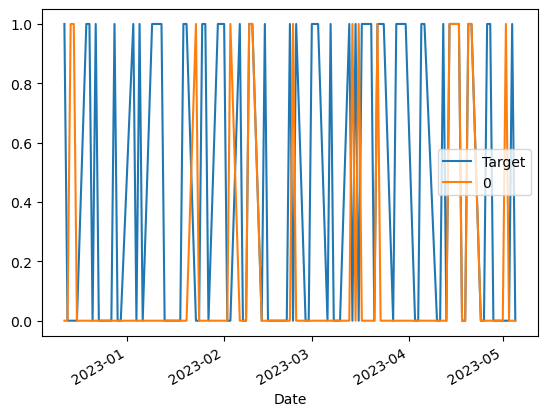

In [24]:
# Visualize the 'combined' dataframe using a line plot
combined.plot()

In [25]:
# backtesting

In [26]:
from typing import Any, List

# functionalize the prediction model
def predict(train: pd.DataFrame, test: pd.DataFrame, predictors: List[str], model: Any) -> pd.DataFrame:
    """
    Generates predictions for a test set using a trained machine learning model.
    
    Args:
        train: DataFrame of the training data, including the target variable.
        test: DataFrame of the test data.
        predictors: List of feature names to use for making predictions.
        model: A trained machine learning model object with a '.fit()' and '.predict()' method.
    
    Returns:
        A DataFrame containing the actual target values and predicted values for the test set.
    """
    
    # fit/'train' model using the specified training data and predictor variables
    model.fit(train[predictors], train['Target'])
    
    # generate predictions using the fitted model with the '.predict()' method passing in 'test' set with the predictors
    preds = model.predict(test[predictors])
    
    # convert the numpy array of predicted values to a pandas Series with the same index as the test data
    # name the Series "Predictions"
    preds = pd.Series(preds, index = test.index, name = 'Predictions') 
    
    # combine the actual target values and predicted values into a single DataFrame for comparison
    combined = pd.concat([test['Target'], preds], axis = 1)
    
    # return the DataFrame with the actual and predicted values
    return combined


In [27]:
# Function for backtesting the model
# every trading year ~ 250 days, thus start of 2500 would be ~ 10 years of data; i.e. starts ~ 10 years back => use 10 years of data to train FIRST model
# step is 250 which is ~ 1 year, ergo train the model for one year.  So, start by using 10 years data to train the 11th year, then 11 years of data to train the 12th year, etc...

def backtest(data: pd.DataFrame, model: Any, predictors: List[str], start: int = 2500, step: int = 250) -> pd.DataFrame:
    """
    Backtests a machine learning model using rolling time windows.

    Parameters:
    -----------
    data: pd.DataFrame
        DataFrame containing stock prices and other features.
    model: Any
        Machine learning model to use.
    predictors: List[str]
        List of features to use for making predictions.
    start: int, optional
        Index of the first row to start the backtest (default is 2500).
    step: int, optional
        Number of rows to include in each test set (default is 250).

    Returns:
    --------
    pd.DataFrame
        A concatenated DataFrame of all the predictions.
    """
    
    # Create an empty list to store all the predictions
    all_predictions = []
    
    # Iterate over the specified range, starting from 'start' and stepping by 'step'; i.e. iterate through data year by year
    for i in range(start, data.shape[0], step):
        
        # Split the data into training and test sets
        train = data.iloc[0:i].copy() # The training set includes all rows up to the current index - i.e. all of years preceding current year
        test =  data.iloc[i:(i+step)].copy() # The test set includes the next 'step' rows - i.e. current year
        
        # Use the predict function to make predictions for the test set
        predictions = predict(train, test, predictors, model)
        
        # Append the predictions to the list of all predictions
        all_predictions.append(predictions)
    
    # Concatenate all the predictions into a single DataFrame and return it
    return pd.concat(all_predictions)


In [28]:
# backtesting the model with sp500 DataFrame, the model we trained earlier, and the list of predictors
# the default start value of 2500 means that we start backtesting using data from 10 years ago
# the default step value of 250 means that we backtest using one year of data at a time
predictions = backtest(sp500, model, predictors)

In [29]:
# examine how many times predited market would go up and how many times predicted market would go down
predictions['Predictions'].value_counts()  # '.value_counts()' will provide a numeric count for how many of each type of prediction was made

0    3391
1    2510
Name: Predictions, dtype: int64

In [30]:
# performance analytics

In [46]:
# Calculating the precision score using predicted values 'preds' and actual values in the test set 'test['Target']'
precision_score_2 = precision_score(predictions['Target'], predictions['Predictions'])

# visualize precision score
print(precision_score_2)

# Calculating the balanced accuracy score using predicted values 'preds' and actual values in the test set 'test['Target']'
balanced_accuracy_score_2 = balanced_accuracy_score(predictions['Target'], predictions['Predictions'])

# visualize balanced accuracy score
print(balanced_accuracy_score_2)

# Calculating the confusion matrix using predicted values 'preds' and actual values in the test set 'test['Target']'
confusion_matrix_2 = confusion_matrix(predictions['Target'], predictions['Predictions'])

# visualize confusion matrix
print(confusion_matrix_2)

# Calculating the classification report using predicted values 'preds' and actual values in the test set 'test['Target']'
classification_report_2 = classification_report(predictions['Target'], predictions['Predictions'])

# Printing the classification report
print(classification_report_2)

0.5712451861360719
0.5088340800550103
[[1902  334]
 [2219  445]]
              precision    recall  f1-score   support

           0       0.46      0.85      0.60      2236
           1       0.57      0.17      0.26      2664

    accuracy                           0.48      4900
   macro avg       0.52      0.51      0.43      4900
weighted avg       0.52      0.48      0.41      4900



In [33]:
# percentage of days market actually went up
predictions['Target'].value_counts() / predictions.shape[0] # value counts of the target divided by the total number of rows

1    0.533638
0    0.466362
Name: Target, dtype: float64

In [34]:
# note above, actual performance of market was better than what we predicted; i.e. market rose ~53% and Machine Learning model predicted ~52%

In [35]:
# expanding our predictors to use in model

In [36]:
# Define a list of horizons in days that will be used to calculate rolling averages of the S&P 500 stock index.
# The list includes values of 2, 5, 60, 250, and 1000, which correspond to different periods of time: two days, one trading week (5 days), 
# three trading months (60 days), one trading year (250 days), and four trading years (1000 days).
horizons = [2, 5, 60, 250, 1000]

# Create an empty list to store the new predictor columns to be added to the dataset.
new_predictors = []

# Loop through each horizon value in the horizons list.
for horizon in horizons:
    # Calculate the rolling average of the S&P 500 stock index for the current horizon value.
    rolling_averages = sp500.rolling(horizon).mean()
    
    # Create a new column name for the ratio of the closing price to the rolling average for the current horizon value.
    ratio_column = f'Close_Ratio_{horizon}'
    
    # Calculate the ratio of the closing price to the rolling average for the current horizon value, 
    # and add it as a new column to the S&P 500 dataset.
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']
    
    # Create a new column name for the trend over the current horizon value.
    trend_column = f'Trend_{horizon}'
    
    # Calculate the trend over the current horizon value by taking the sum of the 'Target' column over the previous horizon period 
    # and add it as a new column to the S&P 500 dataset.
    # The shift(1) method shifts the data by 1 period so that the sum will be taken over the previous horizon period.
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']
    
    # Add the new ratio and trend column names to the new_predictors list.
    new_predictors += [ratio_column, trend_column]


In [37]:
# Drop any rows in the `sp500` DataFrame that contain missing values (i.e., NaN values)
sp500 = sp500.dropna()

# Visualize the modified `sp500` DataFrame that has had missing value rows removed. 
# This allows us to inspect the remaining data and ensure that it is complete and appropriate for analysis.
sp500


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28 00:00:00-04:00,4129.629883,4170.060059,4127.180176,4169.479980,4087800000,4167.870117,0,1.004110,2.0,1.013511,3.0,1.029588,31.0,1.052416,116.0,1.116954,535.0
2023-05-01 00:00:00-04:00,4166.790039,4186.919922,4164.120117,4167.870117,3321370000,4119.580078,0,0.999807,1.0,1.011603,2.0,1.029241,30.0,1.051997,115.0,1.116138,534.0
2023-05-02 00:00:00-04:00,4164.100098,4164.100098,4089.719971,4119.580078,4486130000,4090.750000,0,0.994173,0.0,0.997561,2.0,1.017386,30.0,1.039867,114.0,1.102820,534.0


In [38]:
# Model improvement and optimizing - second model

In [39]:
# re-initialize our model (change model parameters)
# set random state, i.e. seed to specific value to ensure repeatability given specified start point of randomness
# n_estimators specify the number of random decision trees will use; generally accuracy improves with higher number of decision trees
# min_samples_split aids in further preventing 'overfitting'; the higher this value the lower the accuracy, however the higher value will decrease risk of overfit

seed = 42
model = RandomForestClassifier(n_estimators=200, min_samples_split = 50, random_state = seed)

In [49]:
# Update predict function; the prediction model

def predict(train: pd.DataFrame, test: pd.DataFrame, predictors: List[str], model: Any) -> pd.DataFrame:
    """
    Train the specified model using the specified training data and predictor variables, and use the model to predict
    the values of the 'Target' variable for the specified test data.
    
    Parameters:
    train (pd.DataFrame): The training data used to fit the model.
    test (pd.DataFrame): The test data used to generate predictions.
    predictors (List[str]): A list of column names to use as predictor variables.
    model (Any): The model to train and use for predictions.
    
    Returns:
    pd.DataFrame: A DataFrame containing the actual and predicted values of the 'Target' variable.
    """
    
    # Train the model using the specified 'predictors' columns, then attempt to predict the 'Target'
    model.fit(train[predictors], train['Target'])
    
    # Generate predictions with the model using the '.predict()' method passing in 'test' set with the predictors.
    # Predictions are probabilities for the class with the highest probability.
    # Extract the probabilities for the positive class, which is column 1 of the predictions array.
    preds = model.predict_proba(test[predictors])[:,1]
    
    # Convert predicted probabilities to binary predictions:
    # Set predictions >= 0.6 to 1, indicating an expected price increase
    # Set predictions < 0.6 to 0, indicating an expected price decrease or no change
    # these values will reduce number of actual trding days, thereby increase the chance or probability that day of trade price goes up
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    
    # Turn the numpy array into a pandas series and name it 'Predictions'
    preds = pd.Series(preds, index = test.index, name = 'Predictions') 
    
    # Generate a dataframe of actual values (i.e. test['Target']) and predicted values ('preds') concatenation
    combined = pd.concat([test['Target'], preds], axis = 1)
    
    return combined


In [50]:
# backtesting the S&P 500 data with the earlier created model and asociated predictors created earlier.
predictions = backtest(sp500, model, new_predictors)

In [42]:
predictions['Predictions'].value_counts()

0.0    4121
1.0     779
Name: Predictions, dtype: int64

In [51]:
# Calculating the precision score using predicted values 'preds' and actual values in the test set 'test['Target']'
precision_score_3 = precision_score(predictions['Target'], predictions['Predictions'])

# visualize precision score
print(precision_score_3)

# Calculating the balanced accuracy score using predicted values 'preds' and actual values in the test set 'test['Target']'
balanced_accuracy_score_3 = balanced_accuracy_score(predictions['Target'], predictions['Predictions'])

# visualize balanced accuracy score
print(balanced_accuracy_score_3)

# Calculating the confusion matrix using predicted values 'preds' and actual values in the test set 'test['Target']'
confusion_matrix_3 = confusion_matrix(predictions['Target'], predictions['Predictions'])

# visualize confusion matrix
print(confusion_matrix_3)

# Calculating the classification report using predicted values 'preds' and actual values in the test set 'test['Target']'
classification_report_3 = classification_report(predictions['Target'], predictions['Predictions'])

# Printing the classification report
print(classification_report_3)

0.5712451861360719
0.5088340800550103
[[1902  334]
 [2219  445]]
              precision    recall  f1-score   support

           0       0.46      0.85      0.60      2236
           1       0.57      0.17      0.26      2664

    accuracy                           0.48      4900
   macro avg       0.52      0.51      0.43      4900
weighted avg       0.52      0.48      0.41      4900

